In [237]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from analytic_wfm.peakdetect import *

%run "Fonctions.ipynb"
%run "Signal.ipynb"

In [254]:
signaux = pd.DataFrame()
files = find_all_extension('../Millau/Resultats/', '.txt')
for elt in files:
    # Récupération des signaux
    siwim_sig = list_multiple_var('A0', var_to=9) + list_multiple_var('A', 10, 21)
    signaux = pd.concat([signaux, recover_sig(elt, siwim_sig)], axis=1)
    
#     # Calcul rapport signal à bruit (Plus c'est grand, mieux c'est !)
#     all_sig = pd.DataFrame()
#     for col in signaux.columns[1:]:
#         df = pd.DataFrame([[col, signaux.loc[:,col].std()/signaux.loc[:int(0.3*len(signaux)),col].std()]], columns=["Name", "S/N"])
#         all_sig = all_sig.append(df)
    
#     # Selection du signal
#     sig = all_sig.reset_index(drop=True).sort_values(by="S/N", ascending=False).iloc[[0],0]
#     best_sig = signaux.loc[:,[signaux.iloc[:,0].name, sig[0]]]
    
#     # Remise à l'échelle 0 du signal
#     signaux = supperposition_signaux(best_sig, 10)
#     signaux.columns = ['time', 'amplitude']
#     sig = Signal("sig-1", signaux)

In [ ]:
test = []
for elt in final_df.columns:
    if 'time' in elt:
        test.append(elt)
        
final_df[test].isnull().sum()[final_df[test].isnull().sum() == 0].index[0]

In [ ]:
2017-06-20-00-03-34-150
2017-06-20-00-03-41-144
2017-06-20-00-05-50-623
2017-06-20-00-05-57-142
2017-06-20-00-08-22-224
2017-06-20-00-33-07-871
2017-06-20-00-38-57-400
2017-06-20-00-39-22-968
2017-06-20-00-41-37-410
2017-06-20-00-45-20-611
2017-06-20-00-52-24-732
2017-06-20-00-54-50-955
2017-06-20-00-56-40-892
2017-06-20-00-57-12-093
2017-06-20-00-59-34-488

In [227]:
choix = '2017-06-20-00-05-57-142'

In [228]:
# Récupération des signaux
siwim_sig = list_multiple_var('A0', var_to=9) + list_multiple_var('A', 10, 21)
signaux = recover_sig('../Millau/Resultats\\2017-06-20-hh-mm-ss\\2017-06-20-00-mm-ss\\'+ choix +'.txt', siwim_sig)

In [229]:
# Calcul rapport signal à bruit (Plus c'est grand, mieux c'est !)
all_sig = pd.DataFrame()
for col in signaux.columns[1:]:
    df = pd.DataFrame([[col, signaux.loc[:,col].std()/signaux.loc[:int(0.3*len(signaux)),col].std()]], columns=["Name", "S/N"])
    all_sig = all_sig.append(df)
    
lis = all_sig.reset_index(drop=True).sort_values(by="S/N", ascending=False).iloc[[0],0].apply(lambda x: x.split('_')[0]).tolist()

In [230]:
signaux = recover_sig('../Millau/Resultats\\2017-06-20-hh-mm-ss\\2017-06-20-00-mm-ss\\'+ choix +'.txt', lis)

In [231]:
# Somme des signaux
signaux = somme_signaux(signaux)

# Supperposition des signaux
signaux = supperposition_signaux(signaux, 10)
signaux.columns = ['time', 'amplitude']
sig = Signal("sig-1", signaux, lookahead=20, delta=0.2)

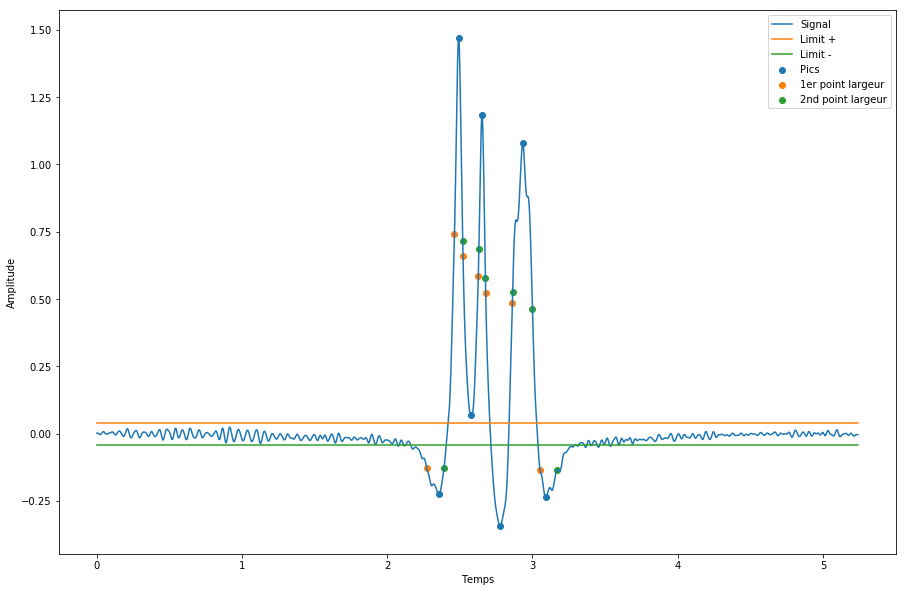

In [232]:
sig.show()

In [233]:
sig.to_df()

,time_0_sig-1,amplitude_0_sig-1,fwhm_0_sig-1,kind_0_sig-1,time_1_sig-1,amplitude_1_sig-1,fwhm_1_sig-1,kind_1_sig-1,time_2_sig-1,amplitude_2_sig-1,...,fwhm_4_sig-1,kind_4_sig-1,time_5_sig-1,amplitude_5_sig-1,fwhm_5_sig-1,kind_5_sig-1,time_6_sig-1,amplitude_6_sig-1,fwhm_6_sig-1,kind_6_sig-1
0,2.49219,1.470391,0.05664,max,2.65234,1.184842,0.04883,max,2.93359,1.077972,...,0.10938,min,2.77734,-0.343688,0.18555,min,3.08984,-0.235048,0.11524,min


#### Selection meilleur signal

In [234]:
signaux = supperposition_signaux(test)
pics = calcul_pics(signaux, 6, 0.05, 0.15)
best = best_courbe(signaux, pics)

NameError: name 'test' is not defined

In [ ]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(best[0].iloc[:, 0], best[0].iloc[:, 1])

# Detections des maximas et minimas
plt.scatter(best[1].iloc[:, 0], best[1].iloc[:, 1])

plt.legend([best[0].iloc[:,1].name])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

In [ ]:
var_name = ['pos_min_', 'min_', 'pos_max_', 'max_']
var_list = []

for elt in var_name:
    if elt == var_name[0] or elt == var_name[1]:
        var_list.append(list_multiple_var(elt, 1, len(min_sig)))
    else:
        var_list.append(list_multiple_var(elt, 1, len(max_sig)))

In [ ]:
pos_min = min_sig[[0]].T.reset_index(drop=True)
min_ampl = min_sig[[1]].T.reset_index(drop=True)
pos_max = max_sig[[0]].T.reset_index(drop=True)
max_ampl = max_sig[[1]].T.reset_index(drop=True)

pos_min.columns = var_list[0]
min_ampl.columns = var_list[1]
pos_max.columns = var_list[2]
max_ampl.columns = var_list[3]

In [ ]:
pd.concat([,pos_min, min_ampl, pos_max, max_ampl], axis=1)

#### Somme signaux

In [ ]:
test3['time'] = test.iloc[:,0]
test3['sig'] = test.iloc[:,1] + test.iloc[:,2] + test.iloc[:,3]

In [ ]:
points = peakdetect(test3.iloc[:, 1],test3.iloc[:, 0], lookahead=5, delta=0.04)

In [ ]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(test3.iloc[:,0], test3.iloc[:, 1])

fourchette = 0.15
plt.plot([0, 5.22], [-fourchette, -fourchette])
plt.plot([0, 5.22], [fourchette, fourchette])

# Detections des maximas et minimas
plt.scatter(np.array(points[0] + points[1]).T[0], np.array(points[0] + points[1]).T[1])

plt.legend(['SUM'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()